In [1]:
#Federated Learning takes the machine learning model to the data rather than taking the data 
# to the model.All thats needed is the williness of the device hosting the data to commit
# it's self to the federation process. The client edge devices communicate at least twice
# with the server per training iteration.

import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

import nest_asyncio
nest_asyncio.apply()

import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow_federated as tff
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall

SEED = 1337
tf.random.set_seed(SEED)

In [2]:
df = pd.read_csv('/home/inlab/Downloads/creditcard.csv')
df


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [3]:
# Creating Alice and Bob's splits:
alice_df = df[:len(df.index)//2]
bob_df = df[len(df.index)//2:]


In [4]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
alice_df['Class'].value_counts()

0    142134
1       269
Name: Class, dtype: int64

In [6]:
bob_df['Class'].value_counts()

0    142181
1       223
Name: Class, dtype: int64

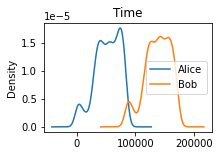

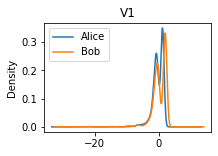

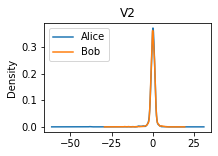

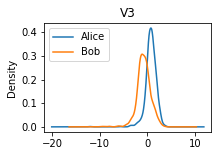

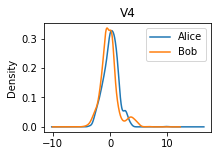

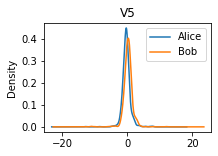

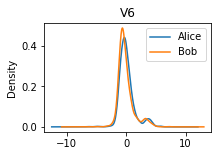

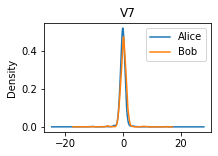

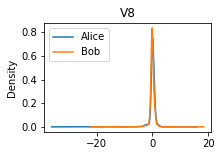

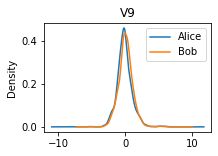

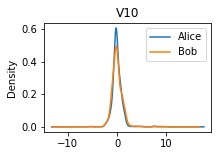

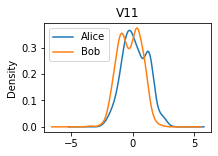

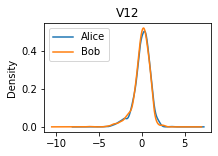

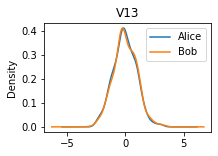

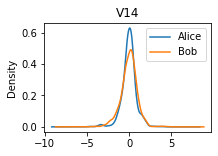

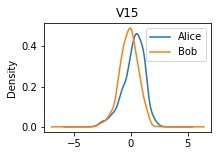

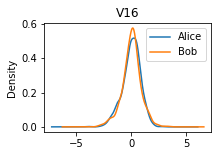

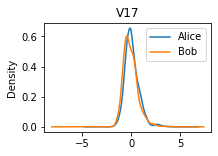

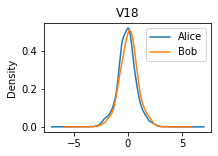

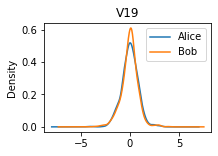

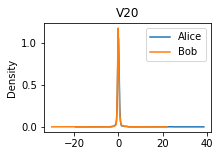

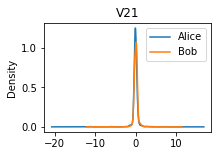

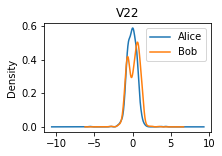

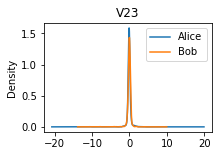

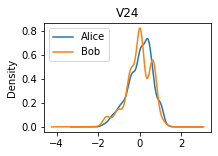

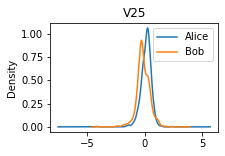

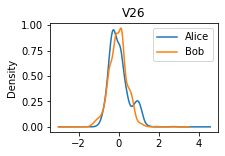

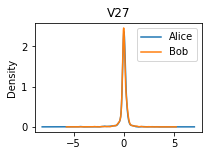

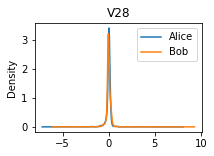

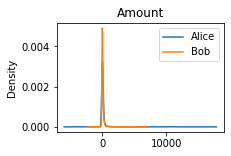

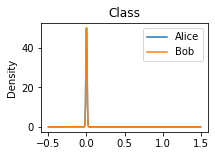

In [7]:
for col in df:
    combined = pd.concat([alice_df[col].reset_index(drop=True), bob_df[col].reset_index(drop=True)], axis=1, ignore_index=True, keys=['Alice', 'Bob'])
    fig, ax = plt.subplots(figsize=(3,2))
    combined.sample(1000, random_state=SEED).plot(kind='density', ax=ax) # Random sample of 1000 to ease computation
    ax.title.set_text(col)
    ax.legend(['Alice', 'Bob'])
    plt.show()

In [8]:
EPOCHS = 100
BATCH_SIZE = 64

In [9]:
def make_tf_dataset(dataframe, negative_ratio=None, batch_size=None):
    dataset = dataframe.drop(['Time'], axis=1)

    # Class balancing
    pos_df = dataset[dataset['Class'] == 1]
    neg_df = dataset[dataset['Class'] == 0]
    if negative_ratio:
        neg_df = neg_df.iloc[random.sample(range(0, len(neg_df)), len(pos_df)*negative_ratio), :]
    balanced_df = pd.concat([pos_df, neg_df], ignore_index=True, sort=False)

    y = balanced_df.pop('Class')
    
    # Dataset creation
    dataset = tf.data.Dataset.from_tensor_slices((balanced_df.values, y.to_frame().values))
    dataset = dataset.shuffle(2048, seed=SEED)
    if batch_size:
        dataset = dataset.batch(batch_size)

    return dataset

In [10]:
train_data, val_data = [], []
for client_data in [alice_df, bob_df]:
    train_df, val_df = train_test_split(client_data, test_size=0.1, random_state=SEED)

    # Scaling (Standardization actually hurts performance) 
    scaler = MinMaxScaler() 
    train_features = scaler.fit_transform(train_df.drop(['Class'], axis=1))
    val_features = scaler.transform(val_df.drop(['Class'], axis=1))

    train_df[train_df.columns.difference(['Class'])] = train_features
    val_df[val_df.columns.difference(['Class'])] = val_features

    # TF Datasets
    train_data.append(make_tf_dataset(train_df, negative_ratio=10, batch_size=BATCH_SIZE))
    val_data.append(make_tf_dataset(val_df, batch_size=1))

<ipython-input-10-786a53fed8c6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[train_df.columns.difference(['Class'])] = train_features
/home/inlab/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-10-786a53fed8c6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [11]:
def input_spec():
    return (
        tf.TensorSpec([None, 29], tf.float64),
        tf.TensorSpec([None, 1], tf.int64)
    )

def model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(29,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[BinaryAccuracy(), Precision(), Recall()])

In [12]:
trainer = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam()
)

state = trainer.initialize()
train_hist = []
for i in range(EPOCHS):
    state, metrics = trainer.next(state, train_data)
    train_hist.append(metrics)

    print(f"\rRun {i+1}/{EPOCHS}", end="")

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Run 100/100

In [14]:
evaluator = tff.learning.build_federated_evaluation(model_fn)

In [16]:
federated_metrics = evaluator(state.model, val_data)
federated_metrics

OrderedDict([('binary_accuracy', 0.99908715),
             ('precision', 0.7631579),
             ('recall', 0.6304348),
             ('loss', 0.034298535)])

In [21]:
train_data = train_data[0].concatenate(train_data[1])
val_data = val_data[0].concatenate(val_data[1])

TypeError: 'ConcatenateDataset' object is not subscriptable

In [22]:
def model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(29,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[BinaryAccuracy(), Precision(), Recall()],
    )
    
    return model

In [24]:
model = model_fn()
history = model.fit(train_data, epochs=EPOCHS)

Epoch 1/100
78/78 [==============================] - 1s 584us/step - loss: 0.3675 - binary_accuracy: 0.8424 - precision_1: 0.1587 - recall_1: 0.1704
Epoch 2/100
78/78 [==============================] - 0s 590us/step - loss: 0.1252 - binary_accuracy: 0.9625 - precision_1: 0.9962 - recall_1: 0.5897
Epoch 3/100
78/78 [==============================] - 0s 619us/step - loss: 0.0846 - binary_accuracy: 0.9788 - precision_1: 0.9914 - recall_1: 0.7735
Epoch 4/100
78/78 [==============================] - 0s 620us/step - loss: 0.0735 - binary_accuracy: 0.9827 - precision_1: 0.9892 - recall_1: 0.8184
Epoch 5/100
78/78 [==============================] - 0s 614us/step - loss: 0.0768 - binary_accuracy: 0.9835 - precision_1: 0.9893 - recall_1: 0.8274
Epoch 6/100
78/78 [==============================] - 0s 611us/step - loss: 0.0683 - binary_accuracy: 0.9833 - precision_1: 0.9815 - recall_1: 0.8318
Epoch 7/100
78/78 [==============================] - 0s 596us/step - loss: 0.0650 - binary_accuracy: 0.984

78/78 [==============================] - 0s 584us/step - loss: 0.0578 - binary_accuracy: 0.9857 - precision_1: 0.9747 - recall_1: 0.8655
Epoch 56/100
78/78 [==============================] - 0s 593us/step - loss: 0.0612 - binary_accuracy: 0.9849 - precision_1: 0.9745 - recall_1: 0.8565
Epoch 57/100
78/78 [==============================] - 0s 579us/step - loss: 0.0602 - binary_accuracy: 0.9833 - precision_1: 0.9619 - recall_1: 0.8498
Epoch 58/100
78/78 [==============================] - 0s 587us/step - loss: 0.0588 - binary_accuracy: 0.9853 - precision_1: 0.9722 - recall_1: 0.8632
Epoch 59/100
78/78 [==============================] - 0s 573us/step - loss: 0.0606 - binary_accuracy: 0.9859 - precision_1: 0.9796 - recall_1: 0.8632
Epoch 60/100
78/78 [==============================] - 0s 573us/step - loss: 0.0575 - binary_accuracy: 0.9847 - precision_1: 0.9720 - recall_1: 0.8565
Epoch 61/100
78/78 [==============================] - 0s 582us/step - loss: 0.0618 - binary_accuracy: 0.9849 - pr

In [25]:
test_scores = model.evaluate(val_data)
single_metrics = {
    'loss': test_scores[0],
    'binary_accuracy': test_scores[1],
    'precision': test_scores[2],
    'recall': test_scores[3]
}
single_metrics

28482/28482 [==============================] - 10s 334us/step - loss: 0.0232 - binary_accuracy: 0.9960 - precision_1: 0.2624 - recall_1: 0.8043


{'loss': 0.02318018488585949,
 'binary_accuracy': 0.9960325956344604,
 'precision': 0.26241135597229004,
 'recall': 0.804347813129425}

In [26]:
print(f"---Single model metrics---\n{single_metrics}\n")
print(f"---Federated model metrics---\n{dict(federated_metrics)}")

---Single model metrics---
{'loss': 0.02318018488585949, 'binary_accuracy': 0.9960325956344604, 'precision': 0.26241135597229004, 'recall': 0.804347813129425}

---Federated model metrics---
{'binary_accuracy': 0.99908715, 'precision': 0.7631579, 'recall': 0.6304348, 'loss': 0.034298535}
